In [1]:
import dask
import numpy as np
import distributed
from distributed import Client, Future, Scheduler, Worker, Queue, LocalCluster, worker_client, get_client
from dask.highlevelgraph import HighLevelGraph
import dask.array as da
import matplotlib.pyplot as plt

import itertools
import time
import math
import pprint

In [2]:
cluster = LocalCluster(n_workers=2)
client = Client(cluster, asynchronous=True)

/gnu/store/k9kc7cj9w149fnb5zx75ilawa83dljzb-profile/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41609 instead
  warnings.warn(


In [3]:
workers = list(client.scheduler_info()['workers'].keys())
workers

['tcp://127.0.0.1:38259', 'tcp://127.0.0.1:44703']

# generate global numpy array

In [4]:
nb_mpi_ranks = 4
mpi_parallelism = (2, 2)
global_grid_size = (64, 64)
local_grid_size = (global_grid_size[0]//mpi_parallelism[0],
                   global_grid_size[1]//mpi_parallelism[1])

assert mpi_parallelism[0] * mpi_parallelism[1] == nb_mpi_ranks, \
    "the product of the mpi parallelisation must be equal to the number of mpi ranks"
assert global_grid_size[0] % mpi_parallelism[0] == 0, \
    "cannot compute local grid size for x dimension"
assert global_grid_size[1] % mpi_parallelism[1] == 0,\
    "cannot compute local grid size for y dimension"

#global_data = np.random.normal(loc=0.0, scale=0.2, size=(100, 100))

# Create coordinate grid
x = np.linspace(-1, 1, global_grid_size[0])
y = np.linspace(-1, 1, global_grid_size[1])
X, Y = np.meshgrid(x, y)

# Generate 2D Gaussian (bell curve)
sigma = 0.5
global_data_np = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
global_data_da = da.from_array(global_data_np)

# for testing
sum1 = global_data_da.sum().compute()
sum1

1430.0153420523206

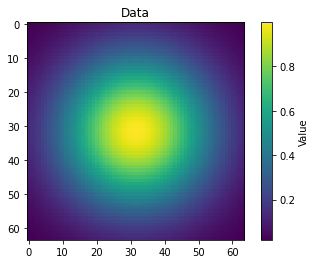

In [5]:
# Plot the matrix
def plot_data(data, title="Data"):
    plt.imshow(data, cmap='viridis', interpolation='none')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.show()

plot_data(global_data_np)

# Tools

In [6]:
def split_array_equal_chunks(arr, block_shape):
    if arr.ndim != 2:
        raise ValueError("Input must be a 2D array")
    
    rows, cols = arr.shape
    block_rows, block_cols = block_shape

    if rows % block_rows != 0 or cols % block_cols != 0:
        raise ValueError(f"Array shape {arr.shape} not divisible by block size ({block_rows}, {block_cols})")

    blocks = []
    for i in range(0, rows, block_rows):
        for j in range(0, cols, block_cols):
            block = arr[i:i+block_rows, j:j+block_cols]
            blocks.append(block)

    return blocks

chunks = split_array_equal_chunks(global_data_np, local_grid_size)

# split general data onto MPI ranks and scatter each rank

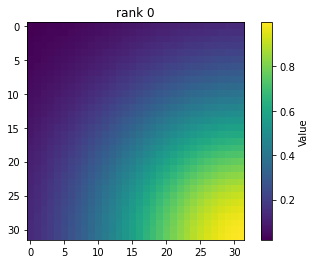

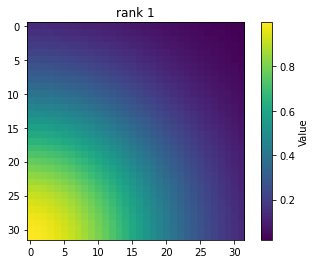

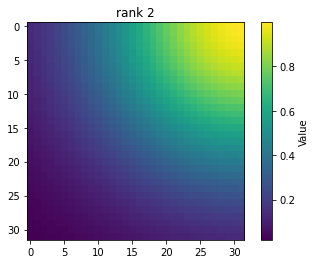

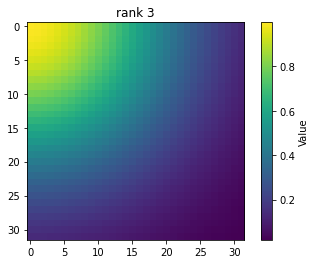

In [7]:
# simulate each MPI rank scatter (sequential)
for rank, chunk in enumerate(chunks):
#     print(chunk)
#     print("scattering MPI rank " + str(rank))
    plot_data(chunk, title="rank " + str(rank))
    
    
    f = client.scatter(chunk, direct=True, workers=workers) # send to workers
    
    metadata = {
        'rank': rank,
        'shape': chunk.shape,
        'dtype': chunk.dtype
    }
    
    Queue("queue_" + str(rank)).put(metadata) # put metadata
    Queue("queue_" + str(rank)).put(f) # put future


# reconstruct full dask array from chunks

In [8]:
items = []
queues = [Queue("queue_" + str(rank)) for rank in range(nb_mpi_ranks)]

for q in queues:
    metadata, data_future = q.get(batch=2) # metadata + data future
#     print(metadata)
    metadata['da'] = da.from_delayed(dask.delayed(data_future), 
                                     shape=metadata["shape"], 
                                     dtype=metadata["dtype"])
    items.append(metadata)

pprint.pp(items)

assert(len(items) == nb_mpi_ranks)

# reconstruct dask array, taking into account rank. top-left is rank 0, bottom-right is last rank.
sorted(items, key=lambda x: x['rank']) # sort by mpi rank
chunks = [item['da'] for item in items]
chunks

[{'rank': 0,
  'shape': (32, 32),
  'dtype': dtype('float64'),
  'da': dask.array<from-value, shape=(32, 32), dtype=float64, chunksize=(32, 32), chunktype=numpy.ndarray>},
 {'rank': 1,
  'shape': (32, 32),
  'dtype': dtype('float64'),
  'da': dask.array<from-value, shape=(32, 32), dtype=float64, chunksize=(32, 32), chunktype=numpy.ndarray>},
 {'rank': 2,
  'shape': (32, 32),
  'dtype': dtype('float64'),
  'da': dask.array<from-value, shape=(32, 32), dtype=float64, chunksize=(32, 32), chunktype=numpy.ndarray>},
 {'rank': 3,
  'shape': (32, 32),
  'dtype': dtype('float64'),
  'da': dask.array<from-value, shape=(32, 32), dtype=float64, chunksize=(32, 32), chunktype=numpy.ndarray>}]


[dask.array<from-value, shape=(32, 32), dtype=float64, chunksize=(32, 32), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(32, 32), dtype=float64, chunksize=(32, 32), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(32, 32), dtype=float64, chunksize=(32, 32), chunktype=numpy.ndarray>,
 dask.array<from-value, shape=(32, 32), dtype=float64, chunksize=(32, 32), chunktype=numpy.ndarray>]

In [9]:
def tile_dask_blocks(blocks):
    """
    Given a flat list of (H, W) Dask arrays, tile them into a single Dask array.
    Assumes all blocks have the same shape.

    Parameters:
        blocks (list of dask.array): Flat list of Dask arrays.

    Returns:
        dask.array.Array: Combined tiled Dask array.
    """
    n_blocks = len(blocks)
    block_shape = blocks[0].shape

    # Check if number of blocks is a perfect square. TODO: may not be the case !
    grid_size = int(math.sqrt(n_blocks))
    if grid_size ** 2 != n_blocks:
        raise ValueError("Number of blocks must be a perfect square for square tiling.")

    # Build a 2D grid from the flat list
    grid = []
    for i in range(grid_size):
        row = blocks[i * grid_size : (i + 1) * grid_size]
        grid.append(row)

    return da.block(grid)


darr = tile_dask_blocks(chunks)
darr

dask.array<concatenate, shape=(64, 64), dtype=float64, chunksize=(32, 32), chunktype=numpy.ndarray>

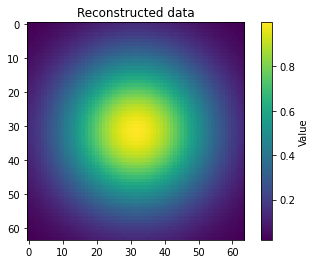

In [10]:
plot_data(darr, title='Reconstructed data')

In [11]:
sum2 = darr.sum().compute()

# check sums
assert(sum1 == sum2)